# Photometry Module

**Lecturer:** Chris Copperwheat<br>
**Jupyter Notebook Author:** Kishalay De & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2020.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2020.html

## Objective
Measure photometric fluxes from astronomical ultraviolet, optical, infrared image data.

## Key steps
- Calibrate images to derive relationship between counts and brightness on sky.
- Use aperture photometry tools to calculate brightness of sources.
- Use Point Spread Function photometry tools to calculate brightness of sources.

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib
* astroquery
* photutils

### External packages
* SExtractor https://www.astromatic.net/software
* PSFex https://www.astromatic.net/software

Let's start by importing a few necessary modules first.

In [6]:
import numpy as np
import numpy.ma as ma
import os
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
import subprocess
from astropy.io.ascii import write

## Test dependencies

In order for this jupyter notebook to function correctly, we must have some external software installed, as described above.  The following step assures that these are installed properly before getting to the rest of the content of this lesson.

In [7]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('sextractor', 'source-extractor'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

sextractor is installed properly as source-extractor. OK
psfex is installed properly as psfex. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.


Let's plot a reduced image from the previous module.

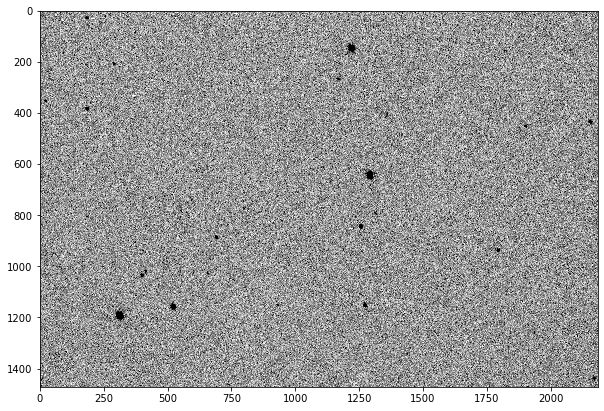

In [10]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Move to the data directory for our analysis

# os.chdir('data/20210319')
imageName = 'UZCom-1-RA.wcs.proc.fits'
f = fits.open(imageName)
data = f[0].data  #This is the image array
header = f[0].header

#Compute some image statistics for scaling the image plot
mean, median, sigma = sigma_clipped_stats(data)

#plot the image with some reasonable scale
plt.figure(figsize=(10,10))
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma, cmap='Greys',  interpolation='nearest')
plt.savefig('Image 1.png', dpi=300, bbox_inches='tight')
plt.show()

## Querying an external catalog

The first step is to obtain the known magnitudes of sources in the field in order to subsequently compare them to the measured instrumental magnitudes. We thus have to refer to some external catalog for sources in the field.  For this tutorial, we will refer the Panstarrs 1 (PS1) catalog. We will query PS1 using astropy's query interface _astroquery_ to query the Vizier server and get a list of sources. First, we have to know the coordinates of the center of this field from the image header.

In [12]:
#strong the image WCS into an object
w = WCS(header)

#Get the RA and Dec of the center of the image
[raImage, decImage] = w.all_pix2world(data.shape[0]/2, data.shape[1]/2, 1)

#Set the box size to search for catalog stars
boxsize = 30 # arcminutes

#Magnitude cut-offs of sources to be cross-matched against
maxmag = 18

Since PS1 is much deeper than a single image from the GROWTH India telescope, we also put a cut-off on the magnitude range of sources we want to calibrate against. For this specific example, a limiting magnitude of 18 mag in g band should suffice. We also want to reject transients and variable sources in PS1 (need a cut-off on the number of detections in the PS1 survey), and only select sources that have $>3 \sigma$ detections in PS1, so we will incorporate those filters into the PS1 query.

In [13]:
from astroquery.vizier import Vizier
#Vizier.VIZIER_SERVER = 'vizier.ast.cam.ac.uk'

catNum = 'II/349'#This is the catalog number of PS1 in Vizier
print('\nQuerying Vizier %s around RA %.4f, Dec %.4f with a radius of %.4f arcmin'%(catNum, raImage, decImage, boxsize))

try:
    #You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":"<<%.2f"%maxmag, "Nd":">>6", "e_gmag":"<<1.086/3"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra = raImage, dec = decImage, unit = (u.deg, u.deg)), radius = str(boxsize)+'m', catalog=catNum, cache=False)
    #query vizier around (ra, dec) with a radius of boxsize
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')


Querying Vizier II/349 around RA 198.1801, Dec 30.3413 with a radius of 30.0000 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag  yFlags 
     deg           deg                         ...   mag     mag           
------------- ------------- ------------------ ... ------- ------- --------
198.389993480  29.875635820 143851983900471407 ...      --      --   114720
198.395236450  29.880830020 143851983950207719 ...      --      --        0
198.371163840  29.870951660 143841983712065861 ...      --      --   114720
198.372471660  29.870582500 143841983726295374 ...      --      --   114720
198.395514500  29.880969430 143851983955707833 ...      --      --   114720
198.380070750  29.877309160 143851983801383369 ...      --      --   115000
198.362081850  29.868835930 143841983620863213 ... 19.3795  0.0500   115000
198.357253170  29.876163710 143851983572372006 ... 18.6049  0.0365   115000
198.347707950  29.868981600 143841983476493434 ... 19.2854  0.0892   115000


Just in case the Vizier query did not go through (this can happen, depending on the load on the Vizier servers), read in the source table in the file ps1_v641cyg.tab. No need to do this step if your query did go through.

The query should have retrieved about 10,000 known sources in this field. We will now filter stars that are away from the edges of the image (same as in the case of the SExtractor detected sources). Note that you can also put additional filters in the catalog sources by just adding more conditions to the the commands below.

Using the same method as we used to figure out the center of the image, use the catalog coordinates from the astropy table to get image coordinates of the sources. Then create a table called good_cat_stars to only store stars that within the pixel range (500, 3500) in both x and y directions in the image.

In [14]:
#Convert the world coordinates of these stars to image coordinates
ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)

#Another round of filtering where we reject sources close to the edges
good_cat_stars = Q[0][np.where((ps1_imCoords[0] < 3500) & (ps1_imCoords[1] < 3500))]
print(good_cat_stars)

   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag  yFlags 
     deg           deg                         ...   mag     mag           
------------- ------------- ------------------ ... ------- ------- --------
198.389993480  29.875635820 143851983900471407 ...      --      --   114720
198.395236450  29.880830020 143851983950207719 ...      --      --        0
198.371163840  29.870951660 143841983712065861 ...      --      --   114720
198.372471660  29.870582500 143841983726295374 ...      --      --   114720
198.395514500  29.880969430 143851983955707833 ...      --      --   114720
198.380070750  29.877309160 143851983801383369 ...      --      --   115000
198.362081850  29.868835930 143841983620863213 ... 19.3795  0.0500   115000
198.357253170  29.876163710 143851983572372006 ... 18.6049  0.0365   115000
198.347707950  29.868981600 143841983476493434 ... 19.2854  0.0892   115000
198.345485070  29.870446790 143841983455165204 ... 18.8890  0.0965 16892216
          ..

Let's get the image coordinates of the filtered good catalog stars and plot them on the image.

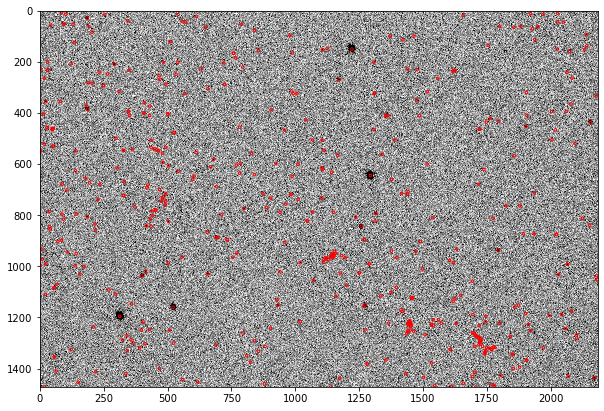

In [15]:
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma, cmap='Greys',  interpolation='nearest')
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 5, edgecolor='r', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
plt.savefig('Image 2.png', dpi=300, bbox_inches='tight')
plt.show()

## Aperture photometry

To start with aperture photometry, we have to identify point sources in this image and compare their brightness to a known catalog. We will use a popular code known as 'Source Extractor' (a.k.a. SExtractor) to detect point sources in the image.

### Source detection

SExtractor is a very powerful code, and can do a large range of complex source detection tasks, but needs to be appropriately configured via its configuration and parameter file to specify the kind of sources we want to detect and the parameters we want to measure.

In this case, you have a configuration file available in the directory designed to detect sources above a 10$\sigma$ threshold from the background and measure it's flux. We'll go over the details, but let's see how SExtractor runs first.

In [31]:
!ls

UZCom-1-RA.wcs.proc.fits  UZcom-3-RA.wcs.proc.fits
UZCom-2-RA.wcs.proc.fits  UZcom-4-RA.wcs.proc.fits


In [34]:
configFile = '../../final/photomCat.sex'
catalogName = imageName+'.cat'
paramName = '.final/photomCat.param'
try:
    command = 'source-extractor -c %s %s -CATALOG_NAME %s -PARAMETERS_NAME %s' % (configFile, imageName, catalogName, paramName)
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print('Could not run sextractor with exit error %s'%err)

Executing command: source-extractor -c ../../final/photomCat.sex UZCom-1-RA.wcs.proc.fits -CATALOG_NAME UZCom-1-RA.wcs.proc.fits.cat -PARAMETERS_NAME ../../final/photomCat.param


Here, we are running SExtractor with a configuration file specified with the '-c' flag and asking it to output the list of sources it deteced to a file called imageName+'.cat' in a format known as the FITS LDAC. The ouput parameters to be produced by SExtractor are in the file 'photomCat.param' and specified by the flag 'PARAMETERS_NAME'. We will now read in the source catalog produced by SExtractor into an astropy table. Before that, here is a function to read FITS LDAC tables with astropy.

In [35]:
def get_table_from_ldac(filename, frame=1):
    """
    Load an astropy table from a fits_ldac by frame (Since the ldac format has column 
    info for odd tables, giving it twce as many tables as a regular fits BinTableHDU,
    match the frame of a table to its corresponding frame in the ldac file).
    
    Parameters
    ----------
    filename: str
        Name of the file to open
    frame: int
        Number of the frame in a regular fits file
    """
    from astropy.table import Table
    if frame>0:
        frame = frame*2
    tbl = Table.read(filename, hdu=frame)
    return tbl

In [36]:
#This is a python wrapper for reading LDAC files produced by SExtractor
sourceTable = get_table_from_ldac(catalogName)
#Let's look at the contents of the table
print(sourceTable.colnames)
print(sourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
       VIGNET [27,27]          X_IMAGE   ...   MAGERR_APER [10]  
             ct                  pix     ...         mag         
---------------------------- ----------- ... --------------------
   -10.60336 ..    -8.850445    185.3977 ...   0.0374 ..   0.0000
      -1e+30 ..       -1e+30   2183.8752 ...   0.2215 ..   0.0000
      -1e+30 ..     14.89022   2146.0352 ...   0.2461 ..   0.0000
      -1e+30 ..     26.43333    234.0203 ...   0.8335 ..   0.0000
   -18.67403 ..       -1e+30   2183.7175 ...   0.1588 ..   0.0000
     6.58783 ..    -35.26141   2170.4302 ...   0.1534 ..   0.0000
      -1e+30 ..       -1e+30   2183.8958 ...   0.2819 ..   0

Note the columns in the output table -- important ones are 'XWIN_IMAGE' and 'YWIN_IMAGE' that are the centroids of the detected stars in image coordinates while 'ALPHAWIN_J2000' and 'DELTAWIN_J2000' are the same in world coordinates. We also have the background subtracted flux of the sources measured in fixed apertures ('FLUX_APER') and the magnitudes in fixed apertures ('MAG_APER').

In order to derive a good photometric solution, we want to find 'clean' sources that are not blended with other objects and are away from the edges of the image, and get their instrumental magnitudes. The SExtractor output has a 'FLAGS' column that indicates unblended sources away from bad pixels with FLAGS = 0 (read the SExtractor manual to find out what other values of the flags mean). In order to get point-like sources, we also want the FWHM of the source to be smaller than about 2 arc seconds that are away from the edges of the image. So let's select the sources that satisfy this condition.

In [37]:
#filter on the sources to select the ones satisfying our criteria
cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']<3500)]
print(cleanSources)

       VIGNET [27,27]          X_IMAGE   ...   MAGERR_APER [10]  
             ct                  pix     ...         mag         
---------------------------- ----------- ... --------------------
   -10.60336 ..    -8.850445    185.3977 ...   0.0374 ..   0.0000
     6.58783 ..    -35.26141   2170.4302 ...   0.1534 ..   0.0000
    19.98919 ..     6.050217   1220.8087 ...   0.0024 ..   0.0000
   -3.790501 ..    -8.790947    207.1848 ...   0.1707 ..   0.0000
   -10.86023 ..    -6.588085    293.0889 ...   0.0266 ..   0.0000
   -20.87477 ..    -6.292618    725.8055 ...   0.1380 ..   0.0000
    5.786812 ..    -9.380287   1755.2397 ...   0.1458 ..   0.0000
   -7.439335 ..     17.03516   2074.6372 ...   0.0839 ..   0.0000
     2.57058 ..    -30.04107    226.2088 ...   0.5509 ..   0.0000
      1.4021 ..    -3.332088   1071.9059 ...   0.1236 ..   0.0000
                         ...         ... ...                  ...
   -15.72083 ..    -20.45346    290.2829 ...   0.0261 ..   0.0000
     2.910

Now overlay these detected sources on the reduced image to see how sextractor performed

### Catalog cross-matching

So far, we have the catalog of sources detected in the image, and an external catalog of sources we want to compare against. The next step is to cross-match the two catalogs and find associations between sources detected in the image and sources on the sky.

In [38]:
sourceCatCoords = SkyCoord(ra=cleanSources['ALPHAWIN_J2000'], dec=cleanSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')

#Now cross match sources

#Set the cross-match distance threshold to 0.6 arcsec, or just about one pixel
photoDistThresh = 0.6
idx_image, idx_ps1, d2d, d3d = ps1CatCoords.search_around_sky(sourceCatCoords, photoDistThresh*u.arcsec)
#idx_image are indexes into sourceCatCoords for the matched sources, while idx_ps1 are indexes into ps1CatCoords for the matched sources

print('Found %d good cross-matches'%len(idx_image))

Found 16 good cross-matches


### Zero-point derivation

Now that we have cross-matched sources between the image and PS1, we can start deriving zero-points. Recall that the instrumental magnitude of a source is related to its physical magnitude via the zero-point relation

<h2> <center>

$m_{app}$ = ZP + $m_{ins}$ <br><br>

$m_{ins} = -2.5 \, \textrm{log} \, (\textrm{Total flux})$

</center></h2>

It should be easy to see that the instrumental magniutde of a source depends on the way you measure the flux, and this is exactly where the different ways of photometry come into play.

As we've already discussed, aperture photometry involves measuring the flux of a source in a fixed aperture of some radius. The amount of flux you measure is also dependent on the size of the aperture you choose. The larger the aperture, the more flux you capture from the wings of the PSF. At the same time, a larger aperture might also have contamination from neighboring sources, so you have to be careful.

In order to be consistent with flux measurements of your catalog calibrators and your target, you have to measure fluxes in the same apertures so that you are 'missing' the same fraction of flux between your calibrators and target source. As the zero-point depends on the difference between the catalog and instrumental magnitudes, the zero-point you derive will also be a function of the size of the aperture you choose -- so an aperture specific zero-point will allow us to account for these issues. Let's see an example of this.

The SExtractor catalogs we got from the image actually also contains aperture photometry for the detected sources in the 'MAG_APER' keyword, so most of our work is actually already done. In this case, the SExtractor parameter file already specified the diameter of the apertures we wanted to measure: 4.0 pixels to 13.0 pixels in steps of 1.0 pixel. 

__Exercise__: Go ahead and look at the SExtractor configuration file and find where these apertures are specified.

To see how the measured instrumental magnitude changes between apertures of different sizes, we can plot the differences between the magnitude measured in the largest aperture (13.0 pixels) and every other aperture and plot the differences. 

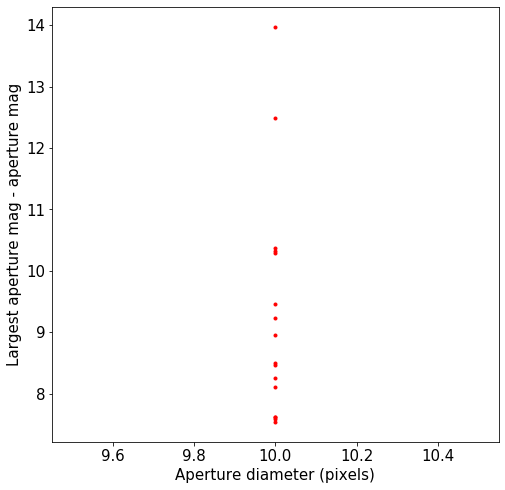

In [39]:
#Apertures in the SExtractor configuration file
aperture_diameter = np.arange(10, 11)

# For each aperture, we are going to compute the magniutde difference between the largest pixel aperture and that specific aperture for every source in cross-matched catalog
magDiff = np.ma.zeros((len(aperture_diameter), len(idx_image)))
for j in range(len(aperture_diameter)):
    magDiff[j] = sigma_clip(cleanSources['MAG_APER'][:,9][idx_image] - cleanSources['MAG_APER'][:,j][idx_image])
# Here, magDiff is a 2D array contaning the difference magnitudes for each source and aperture
    
#Now, let's plot the magnitude differences 
plt.figure(figsize = (8,8))
plt.plot(aperture_diameter, magDiff, 'r.')
plt.xlabel('Aperture diameter (pixels)', fontsize=15)
plt.ylabel('Largest aperture mag - aperture mag', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

As apparent, the magnitudes become systematically fainter for smaller apertures. Recall that the larger the aperture, the more flux and the lower magnitude. This curve is often called as the __Curve of Growth__.

Now, let's overplot the instrumental (for any given aperture) and PS1 magnitudes for the good cross-matched sources.

That is a good correlation between the PS1 and instrumental magnitudes, also showing the small systematic offsets between the magnitudes of different aperture sizes. 

We are ready to derive a zero-point for each aperture. From the earlier equation, the zero-point is just the difference between the catalog and instrumental magnitudes, so we want to measure the average offset between these magnitudes, including rejection of bad outliers that might affect the photometry. The results will be stored in an array of dictionaries containing the mean, median and standard deviation of the zero-point.

In [40]:
zeroPoints = []
for i in range(len(aperture_diameter)):
    #Array of differences between the catalog and instrumental magnitudes
    offsets = ma.array(good_cat_stars['gmag'][idx_ps1] - cleanSources['MAG_APER'][:,i][idx_image])
    #Compute sigma clipped statistics
    zero_mean, zero_med, zero_std = sigma_clipped_stats(offsets)
    zeroDict = {'diameter': aperture_diameter[i], 'zp_mean': zero_mean, 'zp_median': zero_med, 'zp_std': zero_std}
    zeroPoints.append(zeroDict)
    print(zeroDict)

{'diameter': 10, 'zp_mean': 27.673688332519532, 'zp_median': 27.462688034057617, 'zp_std': 0.4455312384427088}


/home/poorvi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/poorvi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


As apparent, the zero-point changes with the size of the aperture. So, when you want to derive photometry, you should measure fluxes in an aperture and apply the zero-point correction for the same aperture to get accurate photometry. This correction for the aperture size is known as an __Aperture correction__. 

We will apply the respective zero-point corrections and compute uncertainties by adding the measured magnitude uncertainties and zero-point uncertainties in quadrature. We will use an astropy based package for photometry called photutils. photutils contains a large number of useful tools for performing photometry on images

In [41]:
from astropy import units as u
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

ra = 198.11145334
dec = 30.35444063
#Specify the position of the target in sky coordinates
position = SkyCoord(ra = ra, dec = dec, unit = u.deg, frame = 'icrs')
#Now set up a set of apertures to measure flux from
aperture_radii = np.array([10.0]) / 2 #Aperutre radii in pixels 
apertures = [SkyCircularAperture(position, r = r * u.pix) for r in aperture_radii]
#Translate the apertures from sky coordinates to pixel coordinates
pix_apertures = [a.to_pixel(w) for a in apertures]
#Now compute the fluxes within these apertures on our data
phot_table = aperture_photometry(data, pix_apertures)
#Translating the output into usable format
for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'    
#print the output
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0
       pix       pix                  
--- --------- --------- --------------
  1 1293.0641 644.09496      336168.24


So far we've measured the flux inside a set of fixed size circular apertures on the image. We now need to compute the background around the source, so we will measure the flux in an annulus around the source coordinates. We will measure the background in annulus of radius 10.0 pixels and width of 10.0 pixels.

In [42]:
#Create the annulus aperture
anuRadius = 15.0
anuWidth = 5.0
annulus_aperture = SkyCircularAnnulus(position, r_in = anuRadius * u.pix, r_out = (anuRadius + anuWidth) * u.pix)
pix_annulus_aperture = annulus_aperture.to_pixel(w)
#Measuring the flux inside an aperture annulus
annulus_phot_table = aperture_photometry(data, pix_annulus_aperture)
for col in annulus_phot_table.colnames:
        annulus_phot_table[col].info.format = '%.8g'    
#print the output
print(annulus_phot_table)

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 1293.0641 644.09496    42856.004


Now we are ready to measure the flux of the source by subtracting the background flux from the flux measured on the source.

In [43]:
#Estimate the background flux per unit pixel area
bkg_mean = annulus_phot_table['aperture_sum'] / pix_annulus_aperture.area
for i in range(len(pix_apertures)):
    #estimate the background flux for this specific aperture size
    bkg_flux = bkg_mean * pix_apertures[i].area
    #subtract the background flux for this aperture from the source flux
    source_flux = phot_table['aperture_sum_%d'%i] - bkg_flux
    source_mag = zeroPoints[i]['zp_median'] - 2.5 * np.log10(source_flux)
    print('Found source magnitude of %.3f for aperture of radius %d pixels'%(source_mag, aperture_radii[i]))

Found source magnitude of 13.666 for aperture of radius 5 pixels


__Question__: Think of a way to estimate the statistical error of this measurement assuming noise in the pixels is Poisson. Also recall that images are usually recorded in units of ADU (digital units), while the Poisson noise is applicable only to electron counts. How do you convert ADUs to electrons?

Note that the aperture photometry magnitudes are completely consistent with each other within the errors of the measurements (the physical magnitude of a source should not depend on the aperture you used to measure the flux), suggesting that the aperture corrections worked fine. Also note that the errors become progressively larger for large apertures since we are accumulating more noise from the background. 

__Question__ : Can you think of another way we could have obtained by the aperture photomtery magnitude for this source? Think of what was contained in the SExtractor catalogs -- how would you extract the magnitudes for the source from the SExtractor catalog?

In [50]:
sourceCatCoords2 = SkyCoord(ra=[198.11145334], dec=[30.35444063], frame='icrs', unit='degree')
ps1CatCoords2 = SkyCoord(ra=cleanSources['ALPHAWIN_J2000'], dec=cleanSources['DELTAWIN_J2000'], frame='icrs', unit='degree')

#Now cross match sources

#Set the cross-match distance threshold to 0.6 arcsec, or just about one pixel
photoDistThresh2 = 2
idx_image2, idx_ps12, d2d2, d3d2 = ps1CatCoords2.search_around_sky(sourceCatCoords2, photoDistThresh2*u.arcsec)
# idx_ps1

In [51]:
print(idx_ps12)

[27]


In [49]:
print(cleanSources["MAG_APER"][int(idx_ps12), 0]+zero_med)
print(cleanSources["MAGERR_APER"][int(idx_ps12), 0]+zero_std)

13.608995025634766
0.4475736621436226


In [46]:
print(idx_ps12)

[27]
